In [1]:
print("="*70)
print("CircuitGuard - Contour Detection and ROI Extraction")
print("="*70)
from google.colab import drive
drive.mount('/content/drive')

CircuitGuard - Contour Detection and ROI Extraction
Mounted at /content/drive


In [2]:
print("\n📦 Installing required libraries...")
!pip install -q opencv-python-headless
!pip install -q opencv-contrib-python-headless

print("✅ Libraries installed successfully!\n")


📦 Installing required libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 15.3 MB/s eta 0:00:00
✅ Libraries installed successfully!



In [3]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import xml.etree.ElementTree as ET
from pathlib import Path
import pickle

# Set visualization style
plt.style.use('default')

In [4]:
print("="*70)
print("STEP 1: Loading Project Configuration")
print("="*70)

# Project paths
PROJECT_ROOT = '/content/drive/MyDrive/CircuitGuard_Project'
DATASET_PATH = f'{PROJECT_ROOT}/dataset/PCB_DATASET'

# Input paths
TEMPLATES_PATH = f'{DATASET_PATH}/PCB_USED'
IMAGES_PATH = f'{DATASET_PATH}/images'
ANNOTATIONS_PATH = f'{DATASET_PATH}/Annotations'

# Output paths
OUTPUT_ROOT = f'{PROJECT_ROOT}/outputs'
PREPROCESSED_PATH = f'{OUTPUT_ROOT}/preprocessed'
DEFECT_MASKS_PATH = f'{OUTPUT_ROOT}/defect_masks'
VISUALIZATIONS_PATH = f'{OUTPUT_ROOT}/visualizations'
ALIGNMENT_PATH = f'{OUTPUT_ROOT}/aligned_images'

# Create output directories
os.makedirs(ALIGNMENT_PATH, exist_ok=True)
os.makedirs(DEFECT_MASKS_PATH, exist_ok=True)


STEP 1: Loading Project Configuration


In [5]:
# Load metadata from Module 1
metadata_path = f'{PROJECT_ROOT}/dataset_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

CATEGORY_MAPPING = metadata['category_mapping']
PCB_IDS = metadata['pcb_ids']

print(f"\n✅ Loaded metadata from Module 1")
print(f"✅ Found {len(PCB_IDS)} PCB designs: {PCB_IDS}")
print(f"✅ Categories: {list(CATEGORY_MAPPING.keys())}")


✅ Loaded metadata from Module 1
✅ Found 10 PCB designs: ['01', '04', '05', '06', '07', '08', '09', '10', '11', '12']
✅ Categories: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']


In [6]:
# Image Alignment Functions
print("\n" + "="*70)
print("STEP 2: Setting Up Image Alignment Pipeline")
print("="*70)

def load_image(image_path):
    """Load image from path"""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")
    return img

def align_images_orb(template_img, defect_img, max_features=5000):
    """
    Align defect image to template using ORB feature matching

    Args:
        template_img: Reference PCB image (grayscale)
        defect_img: Defect PCB image to align (grayscale)
        max_features: Maximum number of features to detect

    Returns:
        aligned_img: Aligned defect image
        homography: Transformation matrix
        matches_count: Number of good matches found
    """

    # Convert to grayscale if needed
    if len(template_img.shape) == 3:
        template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
    else:
        template_gray = template_img

    if len(defect_img.shape) == 3:
        defect_gray = cv2.cvtColor(defect_img, cv2.COLOR_BGR2GRAY)
    else:
        defect_gray = defect_img

    # Initialize ORB detector
    orb = cv2.ORB_create(max_features)

    # Detect keypoints and descriptors
    keypoints1, descriptors1 = orb.detectAndCompute(template_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(defect_gray, None)

    if descriptors1 is None or descriptors2 is None:
        print("⚠️ No features detected!")
        return defect_img, None, 0

    # Match features using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)

    # Apply ratio test (Lowe's ratio test)
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < 0.75 * n.distance:
                good_matches.append(m)

    matches_count = len(good_matches)

    if matches_count < 10:
        print(f"⚠️ Not enough matches found ({matches_count})")
        return defect_img, None, matches_count

    # Extract location of good matches
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches])

    # Find homography matrix
    homography, mask = cv2.findHomography(points2, points1, cv2.RANSAC, 5.0)

    if homography is None:
        print("⚠️ Failed to compute homography")
        return defect_img, None, matches_count

    # Warp defect image to align with template
    height, width = template_gray.shape
    aligned_img = cv2.warpPerspective(defect_img, homography, (width, height))

    return aligned_img, homography, matches_count

def subtract_images(template_img, aligned_defect_img):
    """
    Subtract template from aligned defect image to highlight defects

    Returns:
        diff_img: Absolute difference image
        defect_mask: Binary mask of defects
    """

    # Convert to grayscale if needed
    if len(template_img.shape) == 3:
        template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
    else:
        template_gray = template_img

    if len(aligned_defect_img.shape) == 3:
        defect_gray = cv2.cvtColor(aligned_defect_img, cv2.COLOR_BGR2GRAY)
    else:
        defect_gray = aligned_defect_img

    # Compute absolute difference
    diff_img = cv2.absdiff(template_gray, defect_gray)

    # Apply Otsu's thresholding
    _, defect_mask = cv2.threshold(diff_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Morphological operations to reduce noise
    kernel = np.ones((3, 3), np.uint8)
    defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return diff_img, defect_mask

def parse_xml_annotation(xml_file):
    """Parse Pascal VOC XML annotation file"""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        annotation = {
            'filename': root.find('filename').text,
            'width': int(root.find('size/width').text),
            'height': int(root.find('size/height').text),
            'objects': []
        }

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            obj_data = {
                'name': obj.find('name').text,
                'xmin': int(bbox.find('xmin').text),
                'ymin': int(bbox.find('ymin').text),
                'xmax': int(bbox.find('xmax').text),
                'ymax': int(bbox.find('ymax').text)
            }
            annotation['objects'].append(obj_data)

        return annotation
    except Exception as e:
        return None

print("✅ Image alignment functions ready!")



STEP 2: Setting Up Image Alignment Pipeline
✅ Image alignment functions ready!


In [7]:
# Process Images - Alignment & Subtraction
print("\n" + "="*70)
print("STEP 3: Processing Images - Alignment & Subtraction")
print("="*70)

# Statistics tracking
processing_stats = {
    'total_processed': 0,
    'successful_alignments': 0,
    'failed_alignments': 0,
    'by_category': {},
    'by_pcb_id': {}
}

# Process a limited number of samples first (for testing)
MAX_SAMPLES_PER_CATEGORY = 5  # Change to None to process all images

print(f"\n⚠️ Processing {MAX_SAMPLES_PER_CATEGORY} samples per category for testing...")
print("To process ALL images, set MAX_SAMPLES_PER_CATEGORY = None\n")

for category_template, actual_folder in CATEGORY_MAPPING.items():
    print(f"\n{'='*70}")
    print(f"Processing Category: {category_template}")
    print(f"{'='*70}")

    # Initialize category stats
    processing_stats['by_category'][category_template] = {
        'processed': 0,
        'successful': 0,
        'failed': 0
    }

    # Get image paths
    img_folder = os.path.join(IMAGES_PATH, actual_folder)
    ann_folder = os.path.join(ANNOTATIONS_PATH, actual_folder)

    if not os.path.exists(img_folder):
        print(f"⚠️ Image folder not found: {img_folder}")
        continue

    # Get all defect images
    defect_files = sorted([f for f in os.listdir(img_folder)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    # Limit samples if specified
    if MAX_SAMPLES_PER_CATEGORY:
        defect_files = defect_files[:MAX_SAMPLES_PER_CATEGORY]

    # Process each defect image
    for defect_file in tqdm(defect_files, desc=f"Processing {category_template}"):
        try:
            # Extract PCB ID from filename
            pcb_id = defect_file.split('_')[0]

            # Find corresponding template
            template_file = None
            for tf in os.listdir(TEMPLATES_PATH):
                if tf.startswith(f"{pcb_id}."):
                    template_file = tf
                    break

            if template_file is None:
                print(f"⚠️ Template not found for PCB ID {pcb_id}")
                processing_stats['failed_alignments'] += 1
                processing_stats['by_category'][category_template]['failed'] += 1
                continue

            # Load images
            template_path = os.path.join(TEMPLATES_PATH, template_file)
            defect_path = os.path.join(img_folder, defect_file)

            template_img = load_image(template_path)
            defect_img = load_image(defect_path)

            # Align images
            aligned_img, homography, matches_count = align_images_orb(template_img, defect_img)

            if homography is None:
                processing_stats['failed_alignments'] += 1
                processing_stats['by_category'][category_template]['failed'] += 1
                continue

            # Subtract images
            diff_img, defect_mask = subtract_images(template_img, aligned_img)

            # Save aligned image
            aligned_output_dir = os.path.join(ALIGNMENT_PATH, actual_folder)
            os.makedirs(aligned_output_dir, exist_ok=True)

            aligned_output_path = os.path.join(aligned_output_dir, defect_file)
            cv2.imwrite(aligned_output_path, aligned_img)

            # Save defect mask
            mask_output_dir = os.path.join(DEFECT_MASKS_PATH, actual_folder)
            os.makedirs(mask_output_dir, exist_ok=True)

            mask_filename = defect_file.replace('.jpg', '_mask.png')
            mask_output_path = os.path.join(mask_output_dir, mask_filename)
            cv2.imwrite(mask_output_path, defect_mask)

            # Update statistics
            processing_stats['successful_alignments'] += 1
            processing_stats['by_category'][category_template]['successful'] += 1
            processing_stats['by_category'][category_template]['processed'] += 1

            # Track by PCB ID
            if pcb_id not in processing_stats['by_pcb_id']:
                processing_stats['by_pcb_id'][pcb_id] = 0
            processing_stats['by_pcb_id'][pcb_id] += 1

        except Exception as e:
            print(f"\n❌ Error processing {defect_file}: {str(e)}")
            processing_stats['failed_alignments'] += 1
            processing_stats['by_category'][category_template]['failed'] += 1

        processing_stats['total_processed'] += 1

print("\n" + "="*70)
print("PROCESSING COMPLETE")
print("="*70)



STEP 3: Processing Images - Alignment & Subtraction

⚠️ Processing 5 samples per category for testing...
To process ALL images, set MAX_SAMPLES_PER_CATEGORY = None


Processing Category: missing_hole


Processing missing_hole: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]



Processing Category: mouse_bite


Processing mouse_bite: 100%|██████████| 5/5 [00:08<00:00,  1.69s/it]



Processing Category: open_circuit


Processing open_circuit: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]



Processing Category: short


Processing short: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]



Processing Category: spur


Processing spur: 100%|██████████| 5/5 [00:09<00:00,  1.96s/it]



Processing Category: spurious_copper


Processing spurious_copper: 100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


PROCESSING COMPLETE


In [8]:
# Display Processing Statistics
print("\n" + "="*70)
print("STEP 4: Processing Statistics")
print("="*70)

print(f"\n📊 Overall Statistics:")
print(f"  Total Processed: {processing_stats['total_processed']}")
print(f"  Successful: {processing_stats['successful_alignments']}")
print(f"  Failed: {processing_stats['failed_alignments']}")
print(f"  Success Rate: {processing_stats['successful_alignments']/processing_stats['total_processed']*100:.1f}%")

print(f"\n📊 By Category:")
for category, stats in processing_stats['by_category'].items():
    if stats['processed'] > 0:
        success_rate = stats['successful'] / stats['processed'] * 100
        print(f"  {category:20s} | Processed: {stats['processed']:3d} | Success: {stats['successful']:3d} | Failed: {stats['failed']:3d} | Rate: {success_rate:.1f}%")

print(f"\n📊 By PCB ID:")
for pcb_id, count in sorted(processing_stats['by_pcb_id'].items()):
    print(f"  PCB {pcb_id}: {count} images processed")


STEP 4: Processing Statistics

📊 Overall Statistics:
  Total Processed: 30
  Successful: 30
  Failed: 0
  Success Rate: 100.0%

📊 By Category:
  missing_hole         | Processed:   5 | Success:   5 | Failed:   0 | Rate: 100.0%
  mouse_bite           | Processed:   5 | Success:   5 | Failed:   0 | Rate: 100.0%
  open_circuit         | Processed:   5 | Success:   5 | Failed:   0 | Rate: 100.0%
  short                | Processed:   5 | Success:   5 | Failed:   0 | Rate: 100.0%
  spur                 | Processed:   5 | Success:   5 | Failed:   0 | Rate: 100.0%
  spurious_copper      | Processed:   5 | Success:   5 | Failed:   0 | Rate: 100.0%

📊 By PCB ID:
  PCB 01: 30 images processed



STEP 5: Creating Sample Visualizations
✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/alignment_results.png


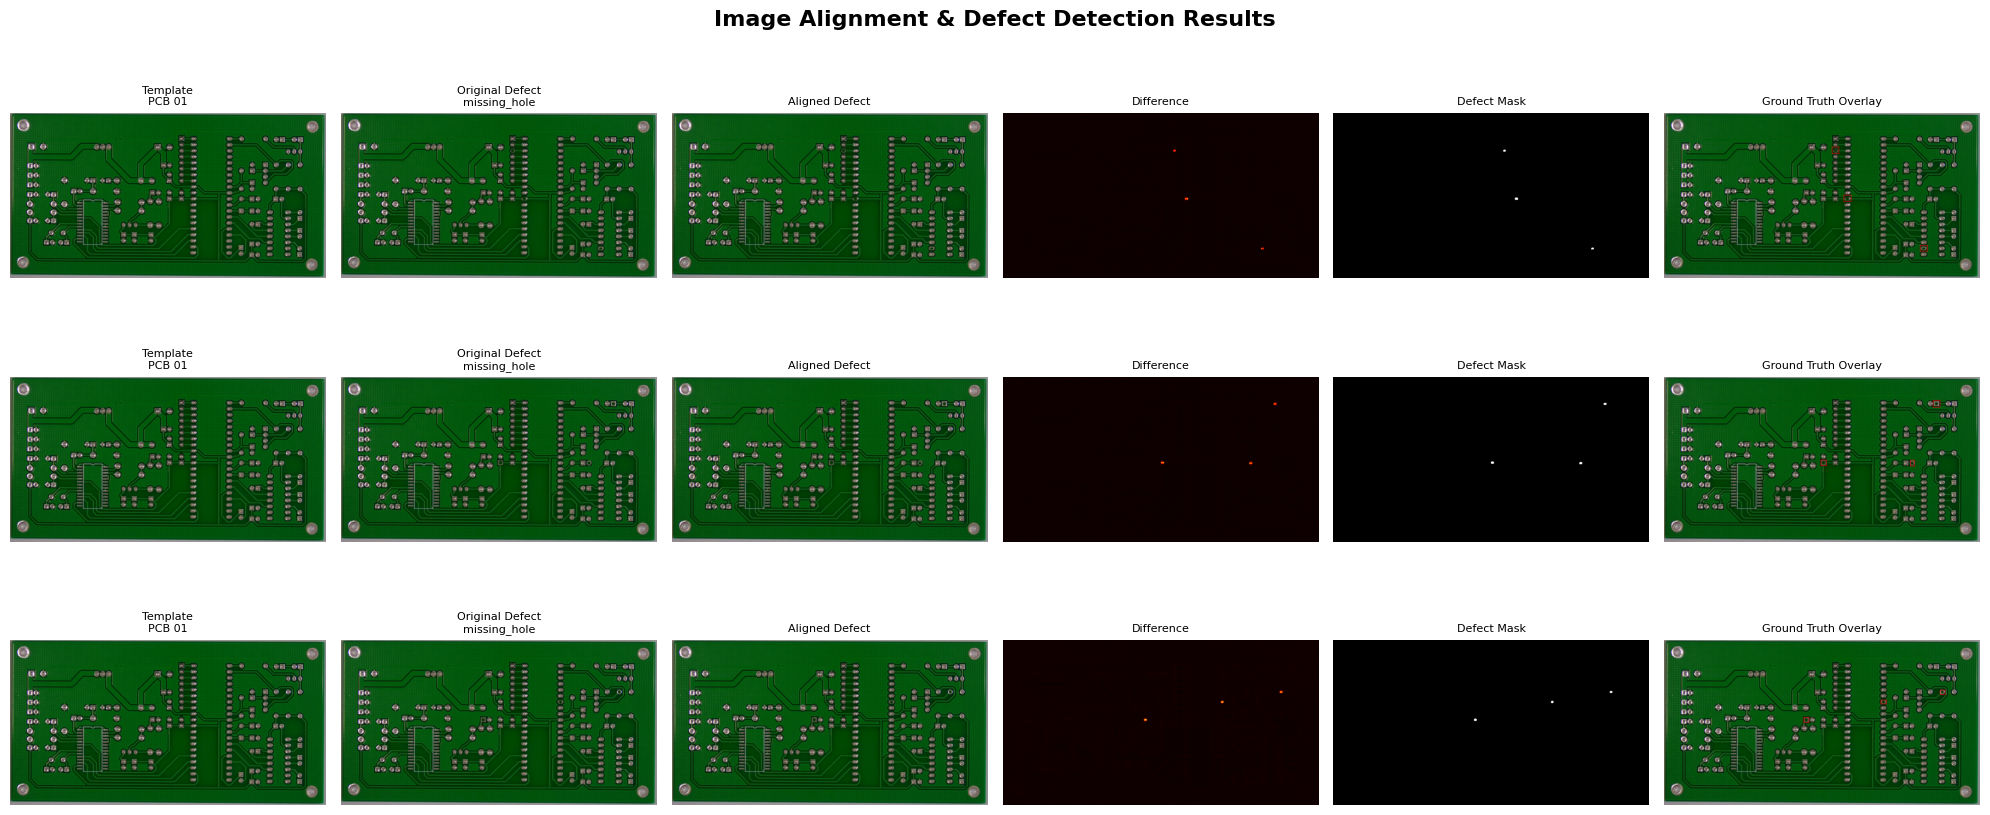

In [9]:
# Visualize Sample Results
print("\n" + "="*70)
print("STEP 5: Creating Sample Visualizations")
print("="*70)

def visualize_alignment_results(num_samples=3):
    """Create visualization showing alignment and subtraction results"""

    # Collect sample images from each category
    samples = []

    for category_template, actual_folder in CATEGORY_MAPPING.items():
        img_folder = os.path.join(IMAGES_PATH, actual_folder)
        aligned_folder = os.path.join(ALIGNMENT_PATH, actual_folder)
        mask_folder = os.path.join(DEFECT_MASKS_PATH, actual_folder)
        ann_folder = os.path.join(ANNOTATIONS_PATH, actual_folder)

        if not os.path.exists(aligned_folder):
            continue

        # Get first few processed images
        aligned_files = sorted([f for f in os.listdir(aligned_folder)
                               if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:num_samples]

        for aligned_file in aligned_files:
            # Extract PCB ID
            pcb_id = aligned_file.split('_')[0]

            # Find template
            template_file = None
            for tf in os.listdir(TEMPLATES_PATH):
                if tf.startswith(f"{pcb_id}."):
                    template_file = tf
                    break

            if template_file is None:
                continue

            # Load images
            template_path = os.path.join(TEMPLATES_PATH, template_file)
            original_path = os.path.join(img_folder, aligned_file)
            aligned_path = os.path.join(aligned_folder, aligned_file)
            mask_file = aligned_file.replace('.jpg', '_mask.png')
            mask_path = os.path.join(mask_folder, mask_file)

            # Load annotation
            xml_file = aligned_file.replace('.jpg', '.xml').replace('.JPG', '.xml')
            xml_path = os.path.join(ann_folder, xml_file)

            if all(os.path.exists(p) for p in [template_path, original_path, aligned_path, mask_path]):
                samples.append({
                    'category': category_template,
                    'template': cv2.imread(template_path),
                    'original': cv2.imread(original_path),
                    'aligned': cv2.imread(aligned_path),
                    'mask': cv2.imread(mask_path),
                    'xml_path': xml_path,
                    'filename': aligned_file
                })

        if len(samples) >= num_samples:
            break

    if not samples:
        print("⚠️ No samples found for visualization")
        return

    # Create visualization
    num_samples = min(len(samples), num_samples)
    fig, axes = plt.subplots(num_samples, 6, figsize=(20, num_samples*3))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Image Alignment & Defect Detection Results', fontsize=16, weight='bold')

    for idx, sample in enumerate(samples[:num_samples]):
        # Convert to RGB for display
        template_rgb = cv2.cvtColor(sample['template'], cv2.COLOR_BGR2RGB)
        original_rgb = cv2.cvtColor(sample['original'], cv2.COLOR_BGR2RGB)
        aligned_rgb = cv2.cvtColor(sample['aligned'], cv2.COLOR_BGR2RGB)
        mask_gray = cv2.cvtColor(sample['mask'], cv2.COLOR_BGR2GRAY)

        # Compute difference
        diff = cv2.absdiff(cv2.cvtColor(sample['template'], cv2.COLOR_BGR2GRAY),
                          cv2.cvtColor(sample['aligned'], cv2.COLOR_BGR2GRAY))

        # Create overlay with ground truth
        overlay = aligned_rgb.copy()
        if os.path.exists(sample['xml_path']):
            annotation = parse_xml_annotation(sample['xml_path'])
            if annotation and annotation['objects']:
                for obj in annotation['objects']:
                    cv2.rectangle(overlay,
                                (obj['xmin'], obj['ymin']),
                                (obj['xmax'], obj['ymax']),
                                (255, 0, 0), 3)

        # Display
        axes[idx, 0].imshow(template_rgb)
        axes[idx, 0].set_title(f"Template\nPCB {sample['filename'].split('_')[0]}", fontsize=8)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(original_rgb)
        axes[idx, 1].set_title(f"Original Defect\n{sample['category']}", fontsize=8)
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(aligned_rgb)
        axes[idx, 2].set_title("Aligned Defect", fontsize=8)
        axes[idx, 2].axis('off')

        axes[idx, 3].imshow(diff, cmap='hot')
        axes[idx, 3].set_title("Difference", fontsize=8)
        axes[idx, 3].axis('off')

        axes[idx, 4].imshow(mask_gray, cmap='gray')
        axes[idx, 4].set_title("Defect Mask", fontsize=8)
        axes[idx, 4].axis('off')

        axes[idx, 5].imshow(overlay)
        axes[idx, 5].set_title("Ground Truth Overlay", fontsize=8)
        axes[idx, 5].axis('off')

    plt.tight_layout()
    plt.savefig(f'{VISUALIZATIONS_PATH}/alignment_results.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {VISUALIZATIONS_PATH}/alignment_results.png")
    plt.show()

# Create visualization
visualize_alignment_results(num_samples=3)

In [10]:
# Save Processing Metadata
print("\n" + "="*70)
print("STEP 6: Saving Processing Metadata")
print("="*70)

# Save processing statistics
processing_metadata = {
    'module': 'Module_2_Preprocessing',
    'statistics': processing_stats,
    'paths': {
        'aligned_images': ALIGNMENT_PATH,
        'defect_masks': DEFECT_MASKS_PATH
    }
}

processing_metadata_path = f'{PROJECT_ROOT}/module2_processing_metadata.json'
with open(processing_metadata_path, 'w') as f:
    json.dump(processing_metadata, f, indent=4)

print(f"✅ Processing metadata saved to: {processing_metadata_path}")



STEP 6: Saving Processing Metadata
✅ Processing metadata saved to: /content/drive/MyDrive/CircuitGuard_Project/module2_processing_metadata.json


In [11]:
#till now
print(f"  ✅ Total images processed: {processing_stats['total_processed']}")
print(f"  ✅ Successful alignments: {processing_stats['successful_alignments']}")
print(f"  ✅ Failed alignments: {processing_stats['failed_alignments']}")
print(f"  ✅ Success rate: {processing_stats['successful_alignments']/max(processing_stats['total_processed'],1)*100:.1f}%")
print(f"  ✅ Aligned images saved to: {ALIGNMENT_PATH}")
print(f"  ✅ Defect masks saved to: {DEFECT_MASKS_PATH}")
print(f"  ✅ Visualizations saved to: {VISUALIZATIONS_PATH}")

  ✅ Total images processed: 30
  ✅ Successful alignments: 30
  ✅ Failed alignments: 0
  ✅ Success rate: 100.0%
  ✅ Aligned images saved to: /content/drive/MyDrive/CircuitGuard_Project/outputs/aligned_images
  ✅ Defect masks saved to: /content/drive/MyDrive/CircuitGuard_Project/outputs/defect_masks
  ✅ Visualizations saved to: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations


In [13]:
print("CircuitGuard - Module 2: Contour Detection & ROI Extraction")
print("\n📦 Installing required libraries...")
!pip install -q opencv-python-headless
!pip install -q scikit-learn

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import xml.etree.ElementTree as ET
from pathlib import Path
from collections import defaultdict
import shutil
from sklearn.model_selection import train_test_split

# Set visualization style
plt.style.use('default')



CircuitGuard - Module 2: Contour Detection & ROI Extraction

📦 Installing required libraries...


In [14]:
# Input paths (from Module 1)
IMAGES_PATH = f'{DATASET_PATH}/images'
ANNOTATIONS_PATH = f'{DATASET_PATH}/Annotations'
TEMPLATES_PATH = f'{DATASET_PATH}/PCB_USED'

# Output paths
OUTPUT_ROOT = f'{PROJECT_ROOT}/outputs'
ROI_CROPS_PATH = f'{OUTPUT_ROOT}/roi_crops'
VISUALIZATIONS_PATH = f'{OUTPUT_ROOT}/visualizations'

# Dataset paths for training
DATASET_OUTPUT_PATH = f'{PROJECT_ROOT}/training_dataset'
TRAIN_PATH = f'{DATASET_OUTPUT_PATH}/train'
VAL_PATH = f'{DATASET_OUTPUT_PATH}/val'
TEST_PATH = f'{DATASET_OUTPUT_PATH}/test'

# Create output directories
os.makedirs(ROI_CROPS_PATH, exist_ok=True)
os.makedirs(DATASET_OUTPUT_PATH, exist_ok=True)

# Load metadata from Module 1
metadata_path = f'{PROJECT_ROOT}/dataset_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

CATEGORY_MAPPING = metadata['category_mapping']
PCB_IDS = metadata['pcb_ids']

print(f"\n✅ Loaded metadata from Module 1")
print(f"✅ Categories: {list(CATEGORY_MAPPING.keys())}")



✅ Loaded metadata from Module 1
✅ Categories: ['missing_hole', 'mouse_bite', 'open_circuit', 'short', 'spur', 'spurious_copper']


In [15]:
# Helper Functions
print("\n" + "="*70)
print("STEP 2: Setting Up Helper Functions")
print("="*70)

def parse_xml_annotation(xml_file):
    """Parse Pascal VOC XML annotation file"""
    try:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        annotation = {
            'filename': root.find('filename').text,
            'width': int(root.find('size/width').text),
            'height': int(root.find('size/height').text),
            'objects': []
        }

        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            obj_data = {
                'name': obj.find('name').text,
                'xmin': int(bbox.find('xmin').text),
                'ymin': int(bbox.find('ymin').text),
                'xmax': int(bbox.find('xmax').text),
                'ymax': int(bbox.find('ymax').text)
            }
            annotation['objects'].append(obj_data)

        return annotation
    except Exception as e:
        return None

def detect_contours_from_image(image_path):
    """
    Detect contours from defect image or mask

    Args:
        image_path: Path to image file

    Returns:
        contours: List of detected contours
        hierarchy: Contour hierarchy
    """

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        return [], None

    # Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Apply thresholding if not already binary
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Morphological operations to clean up
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # Find contours
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return contours, hierarchy

def filter_contours(contours, min_area=100, max_area=50000):
    """
    Filter contours by area to remove noise

    Args:
        contours: List of contours
        min_area: Minimum contour area
        max_area: Maximum contour area

    Returns:
        filtered_contours: List of valid contours
    """

    filtered = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            filtered.append(contour)

    return filtered

def extract_roi_from_bbox(image, xmin, ymin, xmax, ymax, target_size=(128, 128)):
    """
    Extract and resize ROI from bounding box

    Args:
        image: Source image
        xmin, ymin, xmax, ymax: Bounding box coordinates
        target_size: Target size for cropped patch

    Returns:
        roi: Resized ROI patch
    """

    # Ensure coordinates are within image bounds
    h, w = image.shape[:2]
    xmin = max(0, xmin)
    ymin = max(0, ymin)
    xmax = min(w, xmax)
    ymax = min(h, ymax)

    # Crop ROI
    roi = image[ymin:ymax, xmin:xmax]

    # Resize to target size
    if roi.size > 0:
        roi_resized = cv2.resize(roi, target_size, interpolation=cv2.INTER_LANCZOS4)
        return roi_resized

    return None

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes

    Args:
        box1: (xmin, ymin, xmax, ymax)
        box2: (xmin, ymin, xmax, ymax)

    Returns:
        iou: IoU score
    """

    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # Calculate intersection
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    if x_inter_max < x_inter_min or y_inter_max < y_inter_min:
        return 0.0

    inter_area = (x_inter_max - x_inter_min) * (y_inter_max - y_inter_min)

    # Calculate union
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0.0

    return iou

print("✅ Helper functions ready!")


STEP 2: Setting Up Helper Functions
✅ Helper functions ready!


In [16]:
# # # ROI Extraction Pipeline
# Statistics tracking
extraction_stats = {
    'total_images': 0,
    'total_rois_extracted': 0,
    'by_category': {},
    'contour_detection': {
        'with_contours': 0,
        'without_contours': 0
    },
    'bbox_comparison': {
        'xml_bboxes': 0,
        'detected_bboxes': 0,
        'matched_bboxes': 0
    }
}

# Store all extracted ROIs with metadata
all_roi_data = []

# Process each category
for category_template, actual_folder in CATEGORY_MAPPING.items():
    print(f"\n{'='*70}")
    print(f"Processing Category: {category_template}")
    print(f"{'='*70}")

    # Initialize category stats
    extraction_stats['by_category'][category_template] = {
        'images_processed': 0,
        'rois_extracted': 0,
        'avg_rois_per_image': 0
    }

    # Paths
    img_folder = os.path.join(IMAGES_PATH, actual_folder)
    ann_folder = os.path.join(ANNOTATIONS_PATH, actual_folder)
    roi_output_folder = os.path.join(ROI_CROPS_PATH, actual_folder)

    os.makedirs(roi_output_folder, exist_ok=True)

    if not os.path.exists(img_folder):
        print(f"⚠️ Image folder not found: {img_folder}")
        continue

    # Get all images
    image_files = sorted([f for f in os.listdir(img_folder)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    # Process each image
    for img_file in tqdm(image_files, desc=f"Extracting ROIs - {category_template}"):
        try:
            # Load image
            img_path = os.path.join(img_folder, img_file)
            image = cv2.imread(img_path)

            if image is None:
                continue

            # Get XML annotation (ground truth)
            xml_file = img_file.replace('.jpg', '.xml').replace('.JPG', '.xml')
            xml_path = os.path.join(ann_folder, xml_file)

            annotation = None
            if os.path.exists(xml_path):
                annotation = parse_xml_annotation(xml_path)

            if annotation is None or not annotation['objects']:
                print(f"⚠️ No annotation found for {img_file}")
                continue

            # Extract ROIs using XML bounding boxes (ground truth)
            roi_count = 0
            for idx, obj in enumerate(annotation['objects']):
                xmin = obj['xmin']
                ymin = obj['ymin']
                xmax = obj['xmax']
                ymax = obj['ymax']

                # Extract ROI
                roi = extract_roi_from_bbox(image, xmin, ymin, xmax, ymax, target_size=(128, 128))

                if roi is not None:
                    # Save ROI
                    base_name = os.path.splitext(img_file)[0]
                    roi_filename = f"{base_name}_roi_{idx:02d}.jpg"
                    roi_path = os.path.join(roi_output_folder, roi_filename)
                    cv2.imwrite(roi_path, roi)

                    # Store metadata
                    all_roi_data.append({
                        'category': category_template,
                        'original_image': img_file,
                        'roi_filename': roi_filename,
                        'roi_path': roi_path,
                        'bbox': (xmin, ymin, xmax, ymax),
                        'defect_type': obj['name']
                    })

                    roi_count += 1
                    extraction_stats['total_rois_extracted'] += 1
                    extraction_stats['bbox_comparison']['xml_bboxes'] += 1

            # Update stats
            extraction_stats['total_images'] += 1
            extraction_stats['by_category'][category_template]['images_processed'] += 1
            extraction_stats['by_category'][category_template]['rois_extracted'] += roi_count

        except Exception as e:
            print(f"\n❌ Error processing {img_file}: {str(e)}")

# Calculate averages
for category, stats in extraction_stats['by_category'].items():
    if stats['images_processed'] > 0:
        stats['avg_rois_per_image'] = stats['rois_extracted'] / stats['images_processed']

print("\n" + "="*70)
print("ROI EXTRACTION COMPLETE")
print("="*70)


Processing Category: missing_hole


Extracting ROIs - missing_hole: 100%|██████████| 115/115 [00:47<00:00,  2.43it/s]



Processing Category: mouse_bite


Extracting ROIs - mouse_bite: 100%|██████████| 115/115 [00:50<00:00,  2.28it/s]



Processing Category: open_circuit


Extracting ROIs - open_circuit: 100%|██████████| 116/116 [00:50<00:00,  2.31it/s]



Processing Category: short


Extracting ROIs - short: 100%|██████████| 116/116 [00:48<00:00,  2.39it/s]



Processing Category: spur


Extracting ROIs - spur: 100%|██████████| 115/115 [00:45<00:00,  2.51it/s]



Processing Category: spurious_copper


Extracting ROIs - spurious_copper: 100%|██████████| 116/116 [00:47<00:00,  2.46it/s]


ROI EXTRACTION COMPLETE


In [17]:
# Display Extraction Statistics
print(f"\n📊 Overall Statistics:")
print(f"  Total Images Processed: {extraction_stats['total_images']}")
print(f"  Total ROIs Extracted: {extraction_stats['total_rois_extracted']}")
print(f"  Average ROIs per Image: {extraction_stats['total_rois_extracted']/max(extraction_stats['total_images'],1):.2f}")

print(f"\n📊 By Category:")
print("-" * 70)
for category, stats in extraction_stats['by_category'].items():
    print(f"  {category:20s} | Images: {stats['images_processed']:3d} | ROIs: {stats['rois_extracted']:3d} | Avg: {stats['avg_rois_per_image']:.2f}")



📊 Overall Statistics:
  Total Images Processed: 693
  Total ROIs Extracted: 2953
  Average ROIs per Image: 4.26

📊 By Category:
----------------------------------------------------------------------
  missing_hole         | Images: 115 | ROIs: 497 | Avg: 4.32
  mouse_bite           | Images: 115 | ROIs: 492 | Avg: 4.28
  open_circuit         | Images: 116 | ROIs: 482 | Avg: 4.16
  short                | Images: 116 | ROIs: 491 | Avg: 4.23
  spur                 | Images: 115 | ROIs: 488 | Avg: 4.24
  spurious_copper      | Images: 116 | ROIs: 503 | Avg: 4.34


✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/roi_samples.png


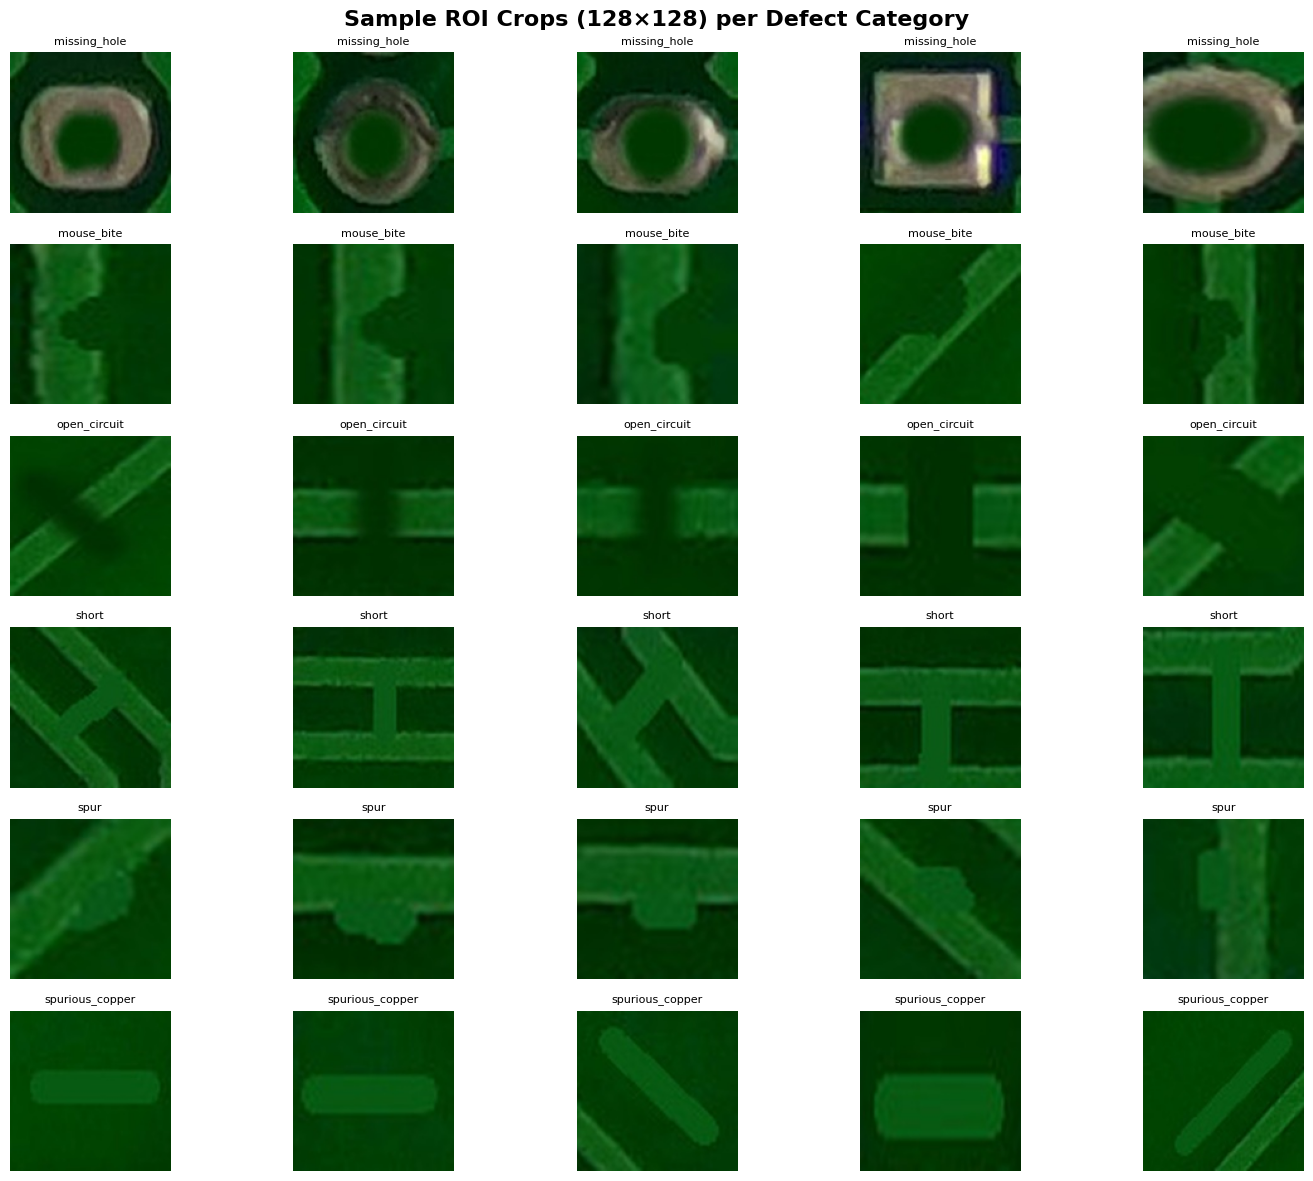

In [18]:
# Visualize Sample ROIs
def visualize_sample_rois(num_samples_per_category=5):
    """Visualize sample ROI crops from each category"""

    fig, axes = plt.subplots(len(CATEGORY_MAPPING), num_samples_per_category,
                            figsize=(15, len(CATEGORY_MAPPING)*2))

    fig.suptitle('Sample ROI Crops (128×128) per Defect Category', fontsize=16, weight='bold')

    for i, (category_template, actual_folder) in enumerate(CATEGORY_MAPPING.items()):
        roi_folder = os.path.join(ROI_CROPS_PATH, actual_folder)

        if not os.path.exists(roi_folder):
            continue

        # Get sample ROIs
        roi_files = sorted([f for f in os.listdir(roi_folder)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:num_samples_per_category]

        for j, roi_file in enumerate(roi_files):
            roi_path = os.path.join(roi_folder, roi_file)
            roi_img = cv2.imread(roi_path)

            if roi_img is not None:
                roi_rgb = cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB)
                axes[i, j].imshow(roi_rgb)
                axes[i, j].set_title(f"{category_template}", fontsize=8)
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.savefig(f'{VISUALIZATIONS_PATH}/roi_samples.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {VISUALIZATIONS_PATH}/roi_samples.png")
    plt.show()

visualize_sample_rois(num_samples_per_category=5)



STEP 6: Visualizing Contour Detection
✅ Saved: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations/contour_detection.png


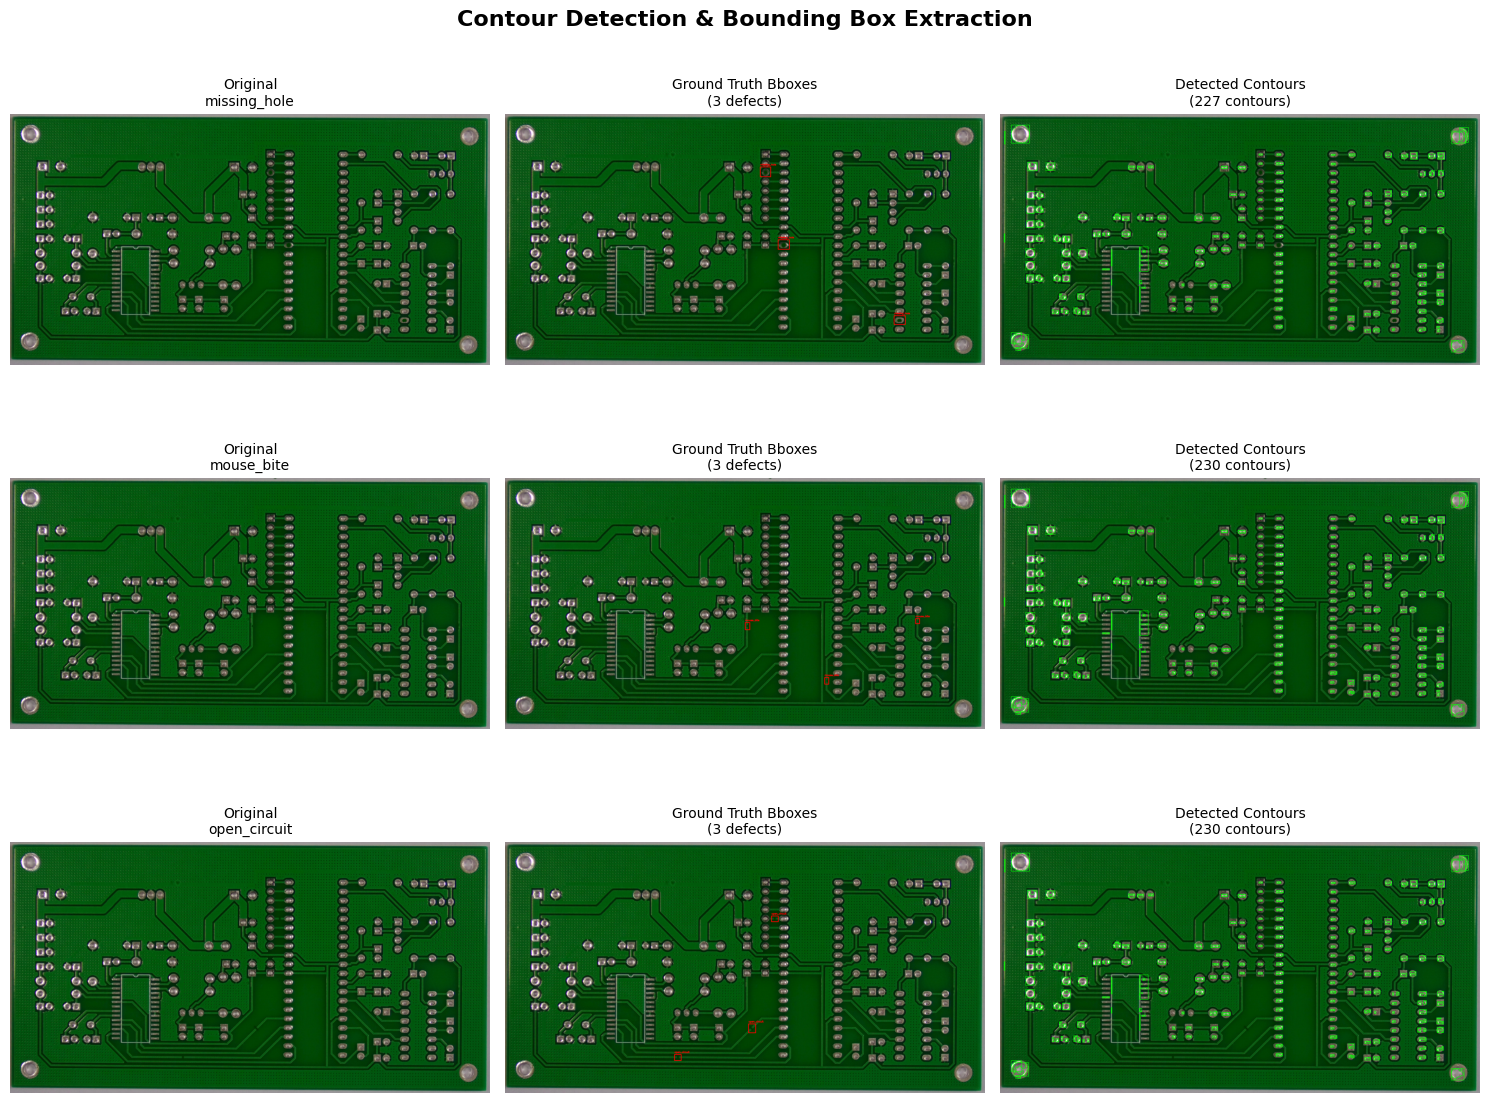

In [19]:
## Visualize Contour Detection on Full Images
print("\n" + "="*70)
print("STEP 6: Visualizing Contour Detection")
print("="*70)

def visualize_contour_detection(num_samples=3):
    """Visualize contour detection and bounding boxes on full images"""

    samples_collected = 0
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*4))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Contour Detection & Bounding Box Extraction', fontsize=16, weight='bold')

    for category_template, actual_folder in CATEGORY_MAPPING.items():
        if samples_collected >= num_samples:
            break

        img_folder = os.path.join(IMAGES_PATH, actual_folder)
        ann_folder = os.path.join(ANNOTATIONS_PATH, actual_folder)

        if not os.path.exists(img_folder):
            continue

        image_files = sorted([f for f in os.listdir(img_folder)
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

        for img_file in image_files[:1]:  # One per category
            if samples_collected >= num_samples:
                break

            # Load image
            img_path = os.path.join(img_folder, img_file)
            image = cv2.imread(img_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Load annotation
            xml_file = img_file.replace('.jpg', '.xml').replace('.JPG', '.xml')
            xml_path = os.path.join(ann_folder, xml_file)

            if not os.path.exists(xml_path):
                continue

            annotation = parse_xml_annotation(xml_path)

            # Create copies for visualization
            img_with_bboxes = image_rgb.copy()
            img_with_contours = image_rgb.copy()

            # Draw ground truth bounding boxes
            if annotation and annotation['objects']:
                for obj in annotation['objects']:
                    cv2.rectangle(img_with_bboxes,
                                (obj['xmin'], obj['ymin']),
                                (obj['xmax'], obj['ymax']),
                                (255, 0, 0), 3)
                    cv2.putText(img_with_bboxes, obj['name'],
                              (obj['xmin'], obj['ymin']-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Detect contours
            contours, _ = detect_contours_from_image(img_path)
            filtered_contours = filter_contours(contours, min_area=100, max_area=50000)

            # Draw contours and their bounding boxes
            for contour in filtered_contours:
                # Draw contour
                cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)

                # Get bounding box
                x, y, w, h = cv2.boundingRect(contour)
                cv2.rectangle(img_with_contours, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Display
            axes[samples_collected, 0].imshow(image_rgb)
            axes[samples_collected, 0].set_title(f"Original\n{category_template}", fontsize=10)
            axes[samples_collected, 0].axis('off')

            axes[samples_collected, 1].imshow(img_with_bboxes)
            axes[samples_collected, 1].set_title(f"Ground Truth Bboxes\n({len(annotation['objects'])} defects)", fontsize=10)
            axes[samples_collected, 1].axis('off')

            axes[samples_collected, 2].imshow(img_with_contours)
            axes[samples_collected, 2].set_title(f"Detected Contours\n({len(filtered_contours)} contours)", fontsize=10)
            axes[samples_collected, 2].axis('off')

            samples_collected += 1

    plt.tight_layout()
    plt.savefig(f'{VISUALIZATIONS_PATH}/contour_detection.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {VISUALIZATIONS_PATH}/contour_detection.png")
    plt.show()

visualize_contour_detection(num_samples=3)

In [20]:
# Create Training Dataset Split
print("STEP 7: Creating Train/Val/Test Dataset Split")

# Split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"\n📊 Split Ratios:")
print(f"  Train: {TRAIN_RATIO*100:.0f}%")
print(f"  Val:   {VAL_RATIO*100:.0f}%")
print(f"  Test:  {TEST_RATIO*100:.0f}%")

# Group ROIs by category
rois_by_category = defaultdict(list)
for roi_data in all_roi_data:
    rois_by_category[roi_data['category']].append(roi_data)

# Split and copy files
split_stats = {}

for category, roi_list in rois_by_category.items():
    print(f"\nSplitting {category}: {len(roi_list)} ROIs")

    # Create category folders
    for split in ['train', 'val', 'test']:
        split_category_path = os.path.join(DATASET_OUTPUT_PATH, split, category)
        os.makedirs(split_category_path, exist_ok=True)

    # Split data
    train_val, test = train_test_split(roi_list, test_size=TEST_RATIO, random_state=42)
    train, val = train_test_split(train_val, test_size=VAL_RATIO/(TRAIN_RATIO+VAL_RATIO), random_state=42)

    split_stats[category] = {
        'total': len(roi_list),
        'train': len(train),
        'val': len(val),
        'test': len(test)
    }

    # Copy files
    for split_name, split_data in [('train', train), ('val', val), ('test', test)]:
        split_category_path = os.path.join(DATASET_OUTPUT_PATH, split_name, category)

        for roi_data in split_data:
            src = roi_data['roi_path']
            dst = os.path.join(split_category_path, roi_data['roi_filename'])
            shutil.copy2(src, dst)

print("\n" + "="*70)
print("Dataset Split Summary")
print("="*70)
print(f"\n{'Category':<20s} | {'Total':>6s} | {'Train':>6s} | {'Val':>6s} | {'Test':>6s}")
print("-" * 70)

total_train = 0
total_val = 0
total_test = 0

for category, stats in split_stats.items():
    print(f"{category:<20s} | {stats['total']:>6d} | {stats['train']:>6d} | {stats['val']:>6d} | {stats['test']:>6d}")
    total_train += stats['train']
    total_val += stats['val']
    total_test += stats['test']

print("-" * 70)
print(f"{'TOTAL':<20s} | {total_train+total_val+total_test:>6d} | {total_train:>6d} | {total_val:>6d} | {total_test:>6d}")


STEP 7: Creating Train/Val/Test Dataset Split

📊 Split Ratios:
  Train: 70%
  Val:   15%
  Test:  15%

Splitting missing_hole: 497 ROIs

Splitting mouse_bite: 492 ROIs

Splitting open_circuit: 482 ROIs

Splitting short: 491 ROIs

Splitting spur: 488 ROIs

Splitting spurious_copper: 503 ROIs

Dataset Split Summary

Category             |  Total |  Train |    Val |   Test
----------------------------------------------------------------------
missing_hole         |    497 |    347 |     75 |     75
mouse_bite           |    492 |    344 |     74 |     74
open_circuit         |    482 |    336 |     73 |     73
short                |    491 |    343 |     74 |     74
spur                 |    488 |    340 |     74 |     74
spurious_copper      |    503 |    351 |     76 |     76
----------------------------------------------------------------------
TOTAL                |   2953 |   2061 |    446 |    446


In [21]:
# Save Module 2 Metadata
module2_metadata = {
    'module': 'Module_2_ROI_Extraction',
    'extraction_stats': extraction_stats,
    'split_stats': split_stats,
    'dataset_paths': {
        'roi_crops': ROI_CROPS_PATH,
        'train': TRAIN_PATH,
        'val': VAL_PATH,
        'test': TEST_PATH
    },
    'total_rois': extraction_stats['total_rois_extracted'],
    'train_size': total_train,
    'val_size': total_val,
    'test_size': total_test
}

module2_metadata_path = f'{PROJECT_ROOT}/module2_metadata.json'
with open(module2_metadata_path, 'w') as f:
    json.dump(module2_metadata, f, indent=4)

print(f"✅ Module 2 metadata saved to: {module2_metadata_path}")


✅ Module 2 metadata saved to: /content/drive/MyDrive/CircuitGuard_Project/module2_metadata.json


In [22]:
## all summary
print(f"  ✅ Images processed: {extraction_stats['total_images']}")
print(f"  ✅ Total ROIs extracted: {extraction_stats['total_rois_extracted']}")
print(f"  ✅ ROI crops saved to: {ROI_CROPS_PATH}")
print(f"  ✅ Training dataset created: {DATASET_OUTPUT_PATH}")
print(f"  ✅ Train samples: {total_train}")
print(f"  ✅ Val samples: {total_val}")
print(f"  ✅ Test samples: {total_test}")
print(f"  ✅ Visualizations saved to: {VISUALIZATIONS_PATH}")


  ✅ Images processed: 693
  ✅ Total ROIs extracted: 2953
  ✅ ROI crops saved to: /content/drive/MyDrive/CircuitGuard_Project/outputs/roi_crops
  ✅ Training dataset created: /content/drive/MyDrive/CircuitGuard_Project/training_dataset
  ✅ Train samples: 2061
  ✅ Val samples: 446
  ✅ Test samples: 446
  ✅ Visualizations saved to: /content/drive/MyDrive/CircuitGuard_Project/outputs/visualizations
